_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 1

## Introduction

In this coding lab you get to implement a pipeline for spike detection and feature extraction, as presented in the lecture:
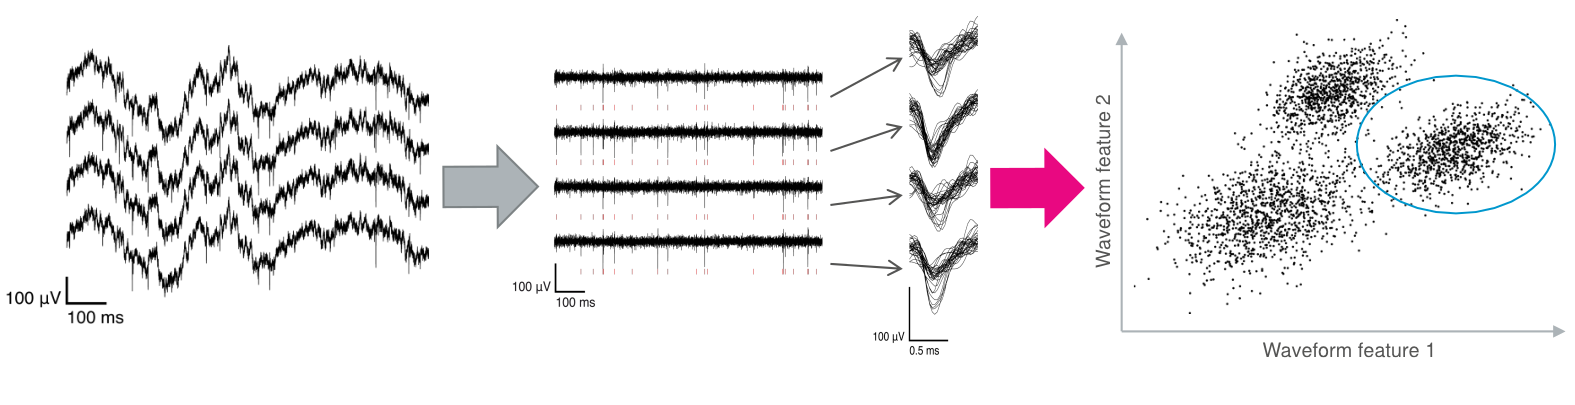

This will later be used for spike sorting (identifying which spike / waveform in the signal was caused by which neuron).

The data used in this notebook was recorded at 30kHz with a tetrode and thus contains the voltage traces of the 4 channels in μV.

_(for more information on the data acquisition, you can have a look at [Ecker et al 2014](https://doi.org/10.1016/j.neuron.2014.02.006), in particular the supplementary material. A similar pipeline is also used in [Ecker et al 2010](https://doi.org/10.1126/science.1179867). Note however that we only use a small portion of the data in this notebook and most of the experiment setup is not relevant here!)_

## Setup
- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-04-22 19:19:54Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

sklearn: 1.3.2

numpy     : 1.24.3
matplotlib: 3.8.2
sklearn   : 1.3.2
pandas    : 2.1.3
scipy     : 1.11.3

Watermark: 2.5.0



In [34]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
# plt.style.use("../matplotlib_style.txt")
plt.style.use("G:/Meine Ablage/Neural Data Science/nds_env/matplotlib_style.txt")

## Load data

In [35]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv(
    "G:/Meine Ablage/Neural Data Science/data/nds_cl_1.csv", header=0, names=cols
)

In [36]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>.

Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 3 pts*


In [ ]:
from scipy.signal import butter, filtfilt


## Current Best Practice
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """
    # -----------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1pt)
    # -----------------------------------------------------------------
    # Use nyquist frequency to not experience aliasing
    # Nyquist = 30 000 / 2.0 = 15 000
    nyq = fs / 2.0
    # Normalize the cutoff frequencies
    # low_norm = 300 / 15 000 = 0.02
    # high_norm = 3000 / 15 000 = 0.2
    # keep everything between 2 and 20 % of the nyquist frequency
    low_norm = low / nyq
    high_norm = high / nyq

    # Design Butterworth bandpass filter
    b, a = butter(order, [low_norm, high_norm], btype="band")
    # High-pass only
    # b, a = butter(order, low_norm / nyq, btype="high") # bad filtered result
    # Low-pass only
    # b, a = butter(order, high_norm / nyq, btype="low") # bad filtered result

    # Apply the filter to each channel of the 4 channels
    xf = x.apply(lambda col: filtfilt(b, a, col), axis=0)

    return xf

In [57]:
xf = filter_signal(x, fs, 500, 4000)

In [58]:
x.shape

(19199999, 4)

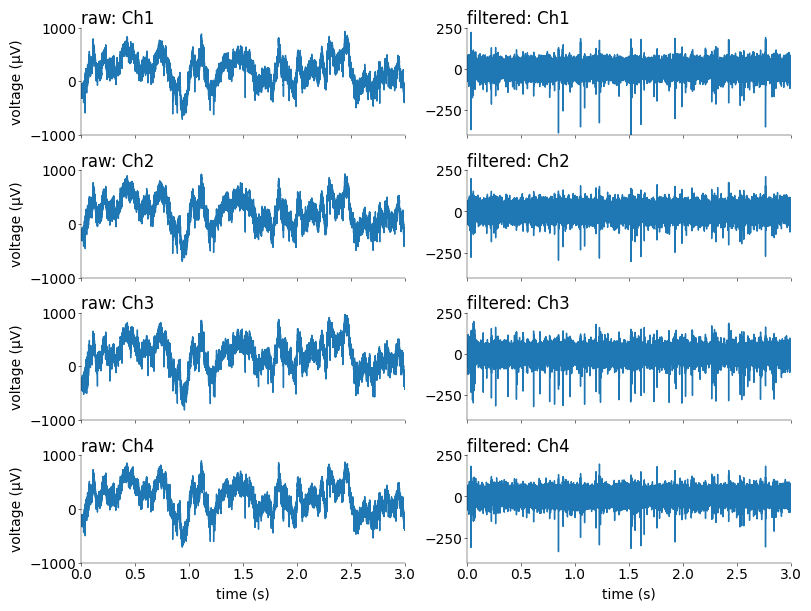

In [59]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# ------------------------------------------------------------------------------------
# Plot raw and filtered signals for all 4 channels and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------

raw = x
filtered = xf

# Number of samples that should be considered for plotting
T = 100000
t = np.arange(0, T) * dt

for i, (raw, filtered) in enumerate(mosaic):

    ### ChatGPT 4.0
    # plot raw singal x and filtered signal xf
    # Define which channel you're working with
    channel_index = i

    # Get the raw and filtered voltage for that channel
    raw_voltage = x.iloc[:T, channel_index]
    filtered_voltage = xf.iloc[:T, channel_index]

    # Get the corresponding time segment
    time_segment = t[:T]

    # Plot them into their respective subplot axes
    ax[raw].plot(time_segment, raw_voltage)
    ax[filtered].plot(time_segment, filtered_voltage)
    ###

    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim((0, 3))
    ax[filtered].set_ylim((-400, 250))

    # Add labels and title
    ax[raw].set_ylabel("voltage (μV)")
    ax[raw].set_title(raw, loc="left")
    ax[filtered].set_title(filtered, loc="left")
    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

### My comments

only keep frequencies in 300-3000 Hz.
GOAL: remove low-frequency and high-frequency noise
WHY Butterworth: flat frequency response, smooth, gradual transition
sampling rate: how many times per second you record the signal from each of the electrodes (measures in Hz (samples per second))
e.g. taking 30.000 voltage measurements per second per channel -> 1/30.000 = 33.3 microseconds -> record brain's electrical activity every 33 microseconds
Herz: measures frequency: how many times something happends per second
e.g. 1000 Hz: 1000 full up- and down- cycles in one second -> 1 cycle in 1 ms


Nyquist frequency: half the sampling rate, because you need at least 2 samples per cycle to accurately capture a wave; more than that = safe, less than that = aliasing (wrong frequency appears in your data)

    - explanation:

### 📐 Aliasing: Sampling a Frequency Above Nyquist

Let’s suppose you try to sample a frequency above the Nyquist limit.

Let:

$$
f = f_s - f', \quad \text{where } f' \in (0, f_s/2)
$$

This means the frequency is just below the sampling rate, and still within the aliased range.

---

#### Step 1: Express the frequency ratio

$$
r = \frac{f}{f_s} = \frac{f_s - f'}{f_s} = 1 - \frac{f'}{f_s}
$$

---

#### Step 2: Define the sampled signal

$$
x[n] = \sin\left(2\pi \cdot \left(1 - \frac{f'}{f_s} \right) \cdot n \right) = \sin\left(2\pi n - 2\pi \cdot \frac{f'}{f_s} \cdot n\right)
$$

---

#### Step 3: Use the identity

$$
\sin(2\pi n - \theta) = \sin(-\theta) = -\sin(\theta)
$$

(since sine is $2\pi$-periodic: $\sin(\theta + 2\pi k) = \sin(\theta)$)

---

#### Step 4: Simplify the signal

$$
x[n] = -\sin\left(2\pi \cdot \frac{f'}{f_s} \cdot n\right)
$$

---

### ✅ Conclusion

This is a discrete sine wave of frequency $f'$, just **flipped in sign**!

So the frequency $f = f_s - f'$ **aliases** to $f'$.  
That’s why frequencies above $f_s/2$ get **folded back** into the range $[0, f_s/2]$.




### Questions
1) Explain your implementation: Which filter and parameters did you choose and why?

We used a band-pass Butterworth filter with a passband of 500–4000 Hz and order 3. This range is standard for isolating spikes, as it removes low-frequency drift and high-frequency noise. We used filtfilt to avoid phase shifts. The Butterworth filter was chosen because it’s smooth and doesn’t introduce ripples in the passband.


2) Which parameters of the function can be adjusted, which are determined by the experiment setup? What is the effect of the adjustable parameters?

The sampling rate (fs) is determined by the experiment setup. It depends on how the data was recorded. The cutoff frequencies (low, high) and filter order are adjustable. Changing the cutoff frequencies shifts which parts of the signal are kept or removed, for example, narrowing the band might remove more noise but could also cut useful signal. The filter order controls how sharp the cutoff is. Higher order means a steeper transition but can also introduce more distortion or ringing if too high.

3) How does the filtered signal look compared to the original? Why is this helpful as preprocessing in our spike detection pipeline?

low-frequency drift and high-frequency noise are removed, and fast, spike-like events stand out more clearly. This makes it easier to detect action potentials by reducing irrelevant signal components.



## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()```.

Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes, also **plot the threshold**.

*Grading: 4 pts*

In [ ]:
# import statistics
from scipy.signal import find_peaks


def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    # --------------------------------------------------------------
    # compute the robust s.d. and calculate the threshold (0.5 pts)
    # --------------------------------------------------------------

    # --------------------------
    # find all spikes (1.5 pts)
    # --------------------------

    n_channels = x.shape[1]
    lockout_samples = int(lockout * fs / 1000)  # convert ms to samples
    spikes = {}

    for ch in range(n_channels):
        signal = x[:, ch]

        # Estimate sigma via MAD
        mad = np.median(np.abs(signal - np.median(signal)))
        sigma_hat = mad / 0.6745
        threshold = -N * sigma_hat  # negative-going spikes
        ### ChatGPT 4.0
        # Detect negative peaks
        spike_indices, _ = find_peaks(
            -signal, height=-threshold, distance=lockout_samples
        )
        spike_times = spike_indices / fs * 1000  # convert to ms

        # Store results
        spikes[ch] = {
            "indices": spike_indices,
            "times_ms": spike_times,
            "threshold": threshold,
        }

    return spikes

In [14]:
spike_data = detect_spikes(xf.to_numpy(), fs)

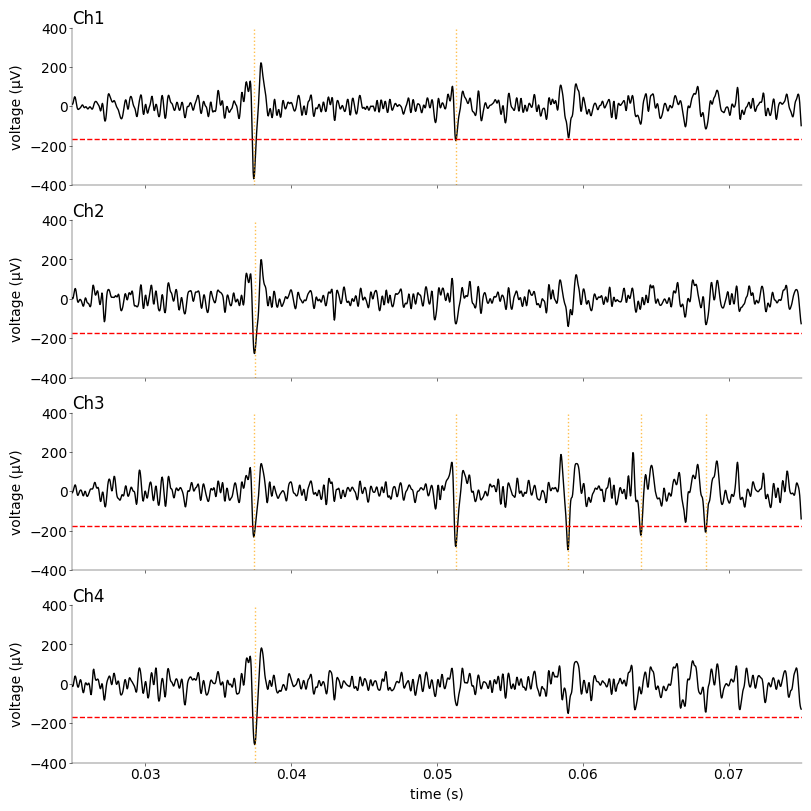

In [ ]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# ------------------------------------------------------------------------------
# plot signal, threshold and detected spikes and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------
### ChatGPT 4.0 
# Time axis (in seconds)
time = np.arange(xf.shape[0]) / fs

# Define time window to plot (e.g., 25 ms to 75 ms = 0.025 to 0.075 seconds)
start_time = 0.025
end_time = 0.075
start_idx = int(start_time * fs)
end_idx = int(end_time * fs)


for i, col in enumerate(cols):

    signal = xf.iloc[:, i]
    ch_time = time[start_idx:end_idx]
    ch_signal = signal[start_idx:end_idx]
    threshold = spike_data[i]["threshold"]
    spike_times = spike_data[i]["times_ms"] / 1000  # convert to seconds

    # Plot filtered signal
    ax[col].plot(ch_time, ch_signal, color="black", label="Filtered signal")

    # Plot threshold line
    ax[col].axhline(threshold, color="red", linestyle="--", label="Threshold")

    # Plot detected spikes
    spike_times_in_window = spike_times[
        (spike_times >= start_time) & (spike_times <= end_time)
    ]
    for spike_t in spike_times_in_window:
        ax[col].axvline(spike_t, color="orange", linestyle=":", alpha=0.7)

    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage (μV)")

    ax[col].set_title(col, loc="left")

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

In [17]:
spike_data

{0: {'indices': array([    1123,     1539,     6801, ..., 19196211, 19197388, 19199625],
        dtype=int64),
  'times_ms': array([3.74333333e+01, 5.13000000e+01, 2.26700000e+02, ...,
         6.39873700e+05, 6.39912933e+05, 6.39987500e+05]),
  'threshold': -164.76607984112286},
 1: {'indices': array([    1125,     6801,    25442, ..., 19196214, 19197390, 19199626],
        dtype=int64),
  'times_ms': array([3.75000000e+01, 2.26700000e+02, 8.48066667e+02, ...,
         6.39873800e+05, 6.39913000e+05, 6.39987533e+05]),
  'threshold': -173.61658696853212},
 2: {'indices': array([    1123,     1539,     1769, ..., 19187874, 19191346, 19193573],
        dtype=int64),
  'times_ms': array([3.74333333e+01, 5.13000000e+01, 5.89666667e+01, ...,
         6.39595800e+05, 6.39711533e+05, 6.39785767e+05]),
  'threshold': -176.3310926983425},
 3: {'indices': array([    1125,    25441,    26736, ..., 19196214, 19197390, 19199626],
        dtype=int64),
  'times_ms': array([3.75000000e+01, 8.48033333

### my comments

Spikes: short, high-frequency voltage deflections caused by neuronal firing; In extracellular recordings, they look like sharp, brief dips (negative peaks).

1. MAD: median absolute deviation (MAD), to handel skewness
2. threshold: 5* MAD



### Questions

1) Are the detected time points well aligned with prominent extrema in the signal? Also compare your detections across channels.


We have a prominent extremum at around about 0.038 seconds which is seen in all four channels. We have a second one at ca 0.052 seconds, that can not so clearly be seen at channel 2 and 4. After 0.06 seconds there are not soo clear prominent signals throughout all the 4 channels.

2) Take one feature of the spikes and explain how that can help us identifying the source neuron of a spike (only based on visual examination of the plot).

One important feature is the spike amplitude. For example at 0.038 seconds, the spike is largest in channel 1, but still visible in channel 2-4. Therefore it likely originates close to that electrode. 

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```.

Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected.
Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 3 pts*

In [ ]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times of the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """
    # -------------------------------
    # extract spike waveforms (1 pt)
    # -------------------------------
    # ChatGPT 4.0
    # grab a short window of the filtered signal at each detetcted spike time & save as waveform
    # 1 ms (30 samples, 30 kHz sampling rate)
    window_size = int(0.001 * fs)  # 1 ms = 30 samples
    pre = window_size // 2
    post = window_size - pre

    waveforms = []
    for spike_time in s:
        if spike_time - pre < 0 or spike_time + post >= x.shape[0]:
            continue  # skip spikes near the edge

        snippet = x[spike_time - pre : spike_time + post, :]
        waveforms.append(snippet)

    return np.stack(waveforms)  # shape: (n_spikes, 30, 4)


# Combine all spike indices across channels (not necessarily sorted)
all_indices = np.concatenate([spike_data[ch]["indices"] for ch in spike_data])
all_indices.sort()  # optional: sort by time

w = extract_waveforms(xf.to_numpy(), all_indices)


Plot first 100 spike waveforms

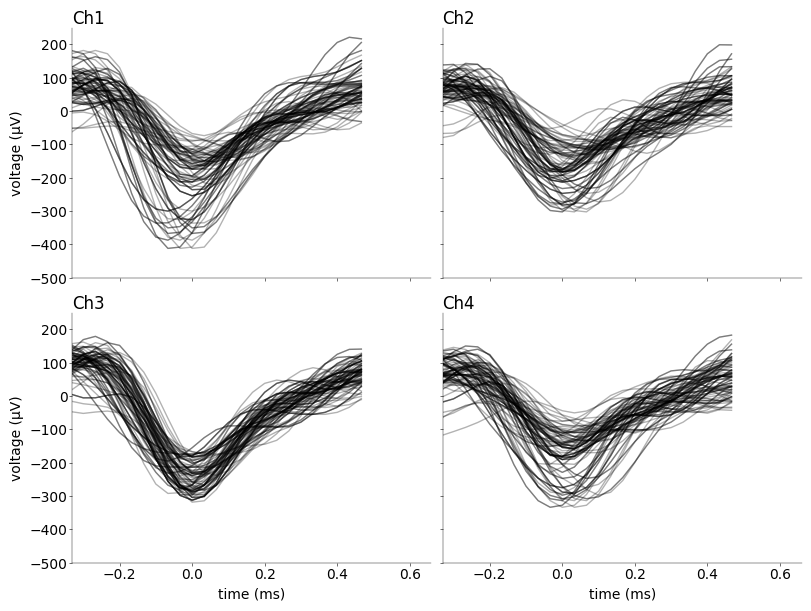

In [ ]:
# ---------------------------------------------------------------------
# plot first and largest 100 spikes and answer the questions (1+1 pts)
# ---------------------------------------------------------------------

# first 100 spikes
###
# Create time axis for waveform window (centered at 0)
window_size = w.shape[1]
t_wave = (np.arange(window_size) - window_size // 2) * (1000 / fs)  # in ms
### 
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    ###
    for wf in w[:100]:
        ax[col].plot(t_wave, wf[:, i], color="black", alpha=0.3)
    ###

    # labeling etc
    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

Plot largest 100 spike waveforms

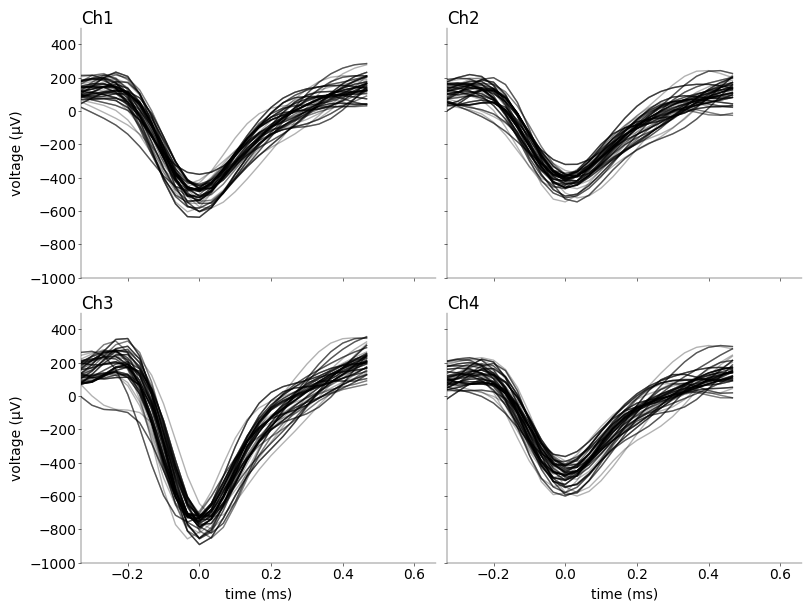

In [24]:
# largest 100 spikes
# Time axis
fs = 30000
window_size = w.shape[1]
t_wave = (np.arange(window_size) - window_size // 2) * (1000 / fs)  # in ms

# Compute min amplitude across channels per spike
peak_amplitudes = np.min(np.min(w, axis=1), axis=1)  # shape: (n_spikes,)
largest_indices = np.argsort(peak_amplitudes)[:100]  # 100 most negative spikes


fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)


for i, col in enumerate(cols):
    for idx in largest_indices:
        ax[col].plot(t_wave, w[idx][:, i], color="black", alpha=0.3)
    # labeling etc
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

### Questions

1) Describe the shape of the spikes.

The spike waveforms in both plots have a fast downward deflection (the main spike), followed by a rebound upward peak, and a return to baseline. The timing is consistent across spikes. The most negative point typically occurs right around 0 ms. 

In the first 100 spikes, the amplitudes are more variable and some spikes are smaller or noisier. In contrast, the largest 100 spikes are more stereotyped, have deeper negative points, and show more consistent shape across all four channels, especially in Ch3, where the spike peak is very sharp and aligned. The first 100 spikes show a negative peak of around –250 µV, while the largest spikes reach much deeper, down to –800 µV (Channel 3). This suggests that the largest spikes likely come from a nearby neuron or a particularly active unit, while the smaller spikes may represent weaker signals or more distant sources.

1) Do the waveforms tend to be similar? If spikes have a similar waveform, what could that mean and what does it mean if the waveforms look different?

Yes they look similar in each group. 

If spikes have a similar waveform, most likely the same neuron is firing. If the spikes have a very different waveform this might indicate, that likely different neurons are firing or there might be noise detected. 

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs. Also return the obtained parameters of the PCA

For one channel, plot the mean and the first three principal axes as calculated by the PCA in the feature space. Interprete them in light of the plots in the previous tasks.

For all pairwise combinations of channels, plot the resulting features of the 1st PCs as scatter plots against each other. Do you see clusters visually?

*Grading: 6 pts*

## PCA
### Questions (1 pt)
1) If we input the data from each channel separately to a PCA, what are the feature dimension of the input?

Number of detected spikes: 50784
length of the window: 1 ms = 30 samples at 30 kHz
Number of channels: 4

Therefore the feature dimesnion of the input is 30.

2) Therefore, what do the Principal Axes the PCA computes represent?

The Principal Axes are the eigenvectors of the covariane matrix of the spike waveforms.
Each Principal Axis represents a direction of maximum variance in the data. 
In our case:
Each row is one spike
Each column is a time point
Therefore we are doing PCA across spike shapes. 

Each Principal Axis can be thought of as a template waveform pattern that explains how the spike shapes differ from one another.
The first Principal Component (PC1) captures the strongest source of variation across all spikes, while the second and third capture additional, orthogonal differences. 

3) Does it make sense to apply preprocessing steps, such as normalization? Have a look at the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). What is applied by default?

As the features are all already in the same scale, normalization is not strictly necessary. By default scikit-learn does only mean-center the data, but doesn't apply normalization or standarization. 



In [60]:
w.shape

(50784, 30, 4)

In [67]:
"""Solution"""


def extract_features(w: np.ndarray) -> np.ndarray:
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)
        the transformed data
    means: np.ndarray, (n_channels, length_window)
        means per channel
    principal_components: np.ndarray, (n_channels, 3, length_window)
        the 'principal axes' obtained by the pca


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    # ----------------------------------------------
    # obtain first 3 principle components (1.5 pts)
    # ----------------------------------------------
    ### ChatGPT 4.0
    n_spikes, length_window, n_channels = w.shape

    b_list = []  # to collect PCA-transformed features per channel
    means = np.zeros((n_channels, length_window))
    principal_components = np.zeros((n_channels, 3, length_window))

    for ch in range(n_channels):
        X = w[:, :, ch]  # shape: (n_spikes, length_window)

        # Apply PCA
        pca = PCA(n_components=3)
        X_transformed = pca.fit_transform(X)

        # -----------------------------------------------------------------------------------------------------
        # Print the fraction of variance explained by the three components combined for each channel (0.5 pts)
        # -----------------------------------------------------------------------------------------------------
        # Store features, means, components
        b_list.append(X_transformed)  # shape: (n_spikes, 3)
        means[ch] = pca.mean_
        principal_components[ch] = pca.components_

        # Print explained variance info
        explained_ratios = pca.explained_variance_ratio_
        total = explained_ratios.sum()
        print(f"\nChannel {ch + 1}:")
        print(f"  PC1: {explained_ratios[0]:.4f}")
        print(f"  PC2: {explained_ratios[1]:.4f}")
        print(f"  PC3: {explained_ratios[2]:.4f}")
        print(f"  Total variance explained: {total:.4f}")

    # Concatenate all channel features into final matrix
    b = np.concatenate(b_list, axis=1)  # shape: (n_spikes, 12)

    return b, means, principal_components

In [68]:
b, means, pcs = extract_features(w)


Channel 1:
  PC1: 0.4705
  PC2: 0.2822
  PC3: 0.0822
  Total variance explained: 0.8349

Channel 2:
  PC1: 0.3843
  PC2: 0.2654
  PC3: 0.1149
  Total variance explained: 0.7646

Channel 3:
  PC1: 0.5100
  PC2: 0.2120
  PC3: 0.1000
  Total variance explained: 0.8221

Channel 4:
  PC1: 0.4085
  PC2: 0.2522
  PC3: 0.1184
  Total variance explained: 0.7791


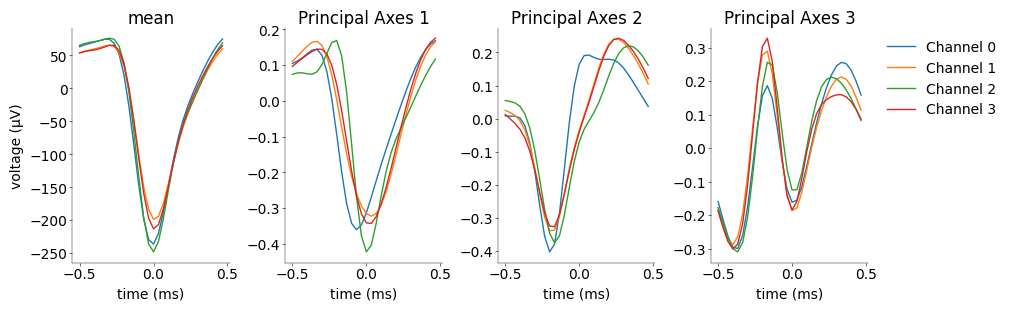

In [28]:
"""Solution"""

# ------------------------------------------------------------------------------------------------------------------
# Plot the mean of each channel and the three principal axes obtained by the PCA and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------------------------------------

mosaic = [
    ["mean", "Principal Axes 1", "Principal Axes 2", "Principal Axes 3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(10, 3), layout="constrained", dpi=100
)
window_size = means.shape[1]
t_wave = (np.arange(window_size) - window_size // 2) * (1000 / fs)  # in ms

for channel in range(4):
    for i, mo in enumerate(np.ravel(mosaic)):
        ax[mo].set_xlabel("time (ms)")
        ax[mo].set_title(mo)

    # Plot the mean waveform for this channel
    ax["mean"].plot(t_wave, means[channel], label=f"Ch{channel+1}")

    # Plot the 3 PCA components for this channel
    for pc_idx in range(3):
        ax[f"Principal Axes {pc_idx+1}"].plot(
            t_wave, pcs[channel, pc_idx], label=f"Ch{channel+1}"
        )


ax[mosaic[0][0]].set_ylabel("voltage (μV)")
ax[mosaic[0][-1]].legend(
    ["Channel " + str(i) for i in range(4)],
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
)
plt.show()

### Questions

1) Compare the plot to the plots of the other tasks. What do you observe?

When comparing the PCA component plots to the raw waveform plots from earlier tasks, we see how PCA captures the key structure of the spike shapes in a very compact way. It reduces the variability into smooth, interpretable patterns. The mean waveform captures the overall spike shape. The first principal axis captures most of the amplitude variation, matching with what we see in the waveform spread. The second and third axes represent more subtle variations in the waveform shape, like width or asymmetry.

2) What does the mean look like? Does this match your expectations?

The mean waveform shows a clear and smooth spike shape with a sharp downward peak around 0 ms, followed by a slower recovery. This matches expectations for an average extracellular spike waveform, especially when spikes are aligned to their peaks. It suggests that the spikes were well-detected and that a dominant, consistent shape, likely from a single neuron or a small group is present in the data. 

3) Explain what it means if a spike has a high value in the first dimension. What is the effect of the other dimensions?

A high value in the first dimension means that the spike strongly expresses the main type of variation found across all spikes — and that variation already explains a large portion of the data.
This could reflect a spike from a particularly active or nearby neuron. The second and third dimensions capture finer differences.


Text(0.5, 0.98, 'Pairwise 1st PCs')

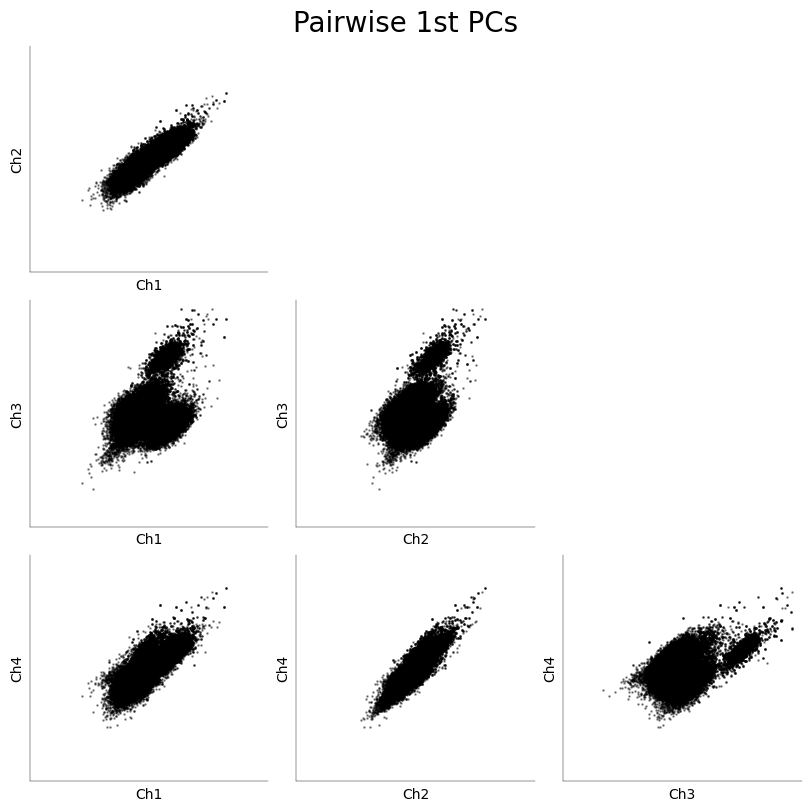

In [ ]:
"""Solution"""

# ----------------------------------------------------------------------------------------------------------
# Create a scatterplot of the projections of the spikes for all pairwise combinations of the 1st PCs (1 pt)
# ----------------------------------------------------------------------------------------------------------

mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# index of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for mo in np.ravel(mosaic):
    if mo == ".":
        continue
    y, x = mo.split(" vs ")

    ### chatgpt
    # Add scatter plot for the pair
    ax[mo].scatter(
        b[:, i[x]],  # x-axis: 1st PC of channel x
        b[:, i[y]],  # y-axis: 1st PC of channel y
        s=3,
        alpha=0.4,
        color="black",
    )

    ax[mo].set_xlabel(x)
    ax[mo].set_ylabel(y)
    ax[mo].set_xlim((-1500, 1500))
    ax[mo].set_ylim((-1500, 1500))
    ax[mo].set_xticks([])
    ax[mo].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [ ]:
# save data for the next Coding Lab

# np.save("../data/nds_cl_1_features", b)
# np.save("../data/nds_cl_1_spiketimes_s", s)
# np.save("../data/nds_cl_1_spiketimes_t", t)
# np.save("../data/nds_cl_1_waveforms", w)